<a href="https://colab.research.google.com/github/Songhyunjeong/thingplug-lora-starter-kit/blob/master/Colaboratory%EC%97%90_%EC%98%A4%EC%8B%A0_%EA%B2%83%EC%9D%84_%ED%99%98%EC%98%81%ED%95%A9%EB%8B%88%EB%8B%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import folium
from folium.plugins import BeautifyIcon
import ast
import numpy as np
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/my_project/traff_version.csv')

# 1. 빈 문자열 및 공백 제거
df = df[df['coords'].astype(str).str.strip() != '']

# 2. coords 열의 NaN 값 제거
df = df.dropna(subset=['coords'])

# 3. coords 열의 문자열을 리스트로 변환
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None

df['coords'] = df['coords'].apply(lambda x: safe_literal_eval(x) if isinstance(x, str) else None)

# 4. 유효한 coords 값만 남기기
df = df[df['coords'].apply(lambda x: isinstance(x, (list, tuple)) and len(x) >= 2)]

# Bus stop data
df_bus = pd.read_csv('/content/drive/MyDrive/my_project/버스정류소현황.csv', encoding='cp949')
df_bus = df_bus[df_bus['시군명'] == '부천시']
df_bus_stop = pd.read_csv('/content/drive/MyDrive/my_project/버스_승차+하차+환승_2024_08_09.csv')

# 버스정류소 승객수 특정 날짜 필터링 ('20230701' 예시)
specific_date = 20240601
filtered_df_bus_stop = df_bus_stop[df_bus_stop['run_ymd'] == specific_date]
# 돌발사고
df_accidents = pd.read_csv('/content/drive/MyDrive/my_project/돌발건수.csv')

# GeoDataFrame 생성
geometry = [LineString(segment) for segment in df['coords']]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# 좌표계를 WGS84로 설정 (Folium은 WGS84 좌표계를 사용)
gdf.set_crs(epsg=4326, inplace=True)

# df_bus를 GeoDataFrame으로 변환
bus_geometry = [Point(xy) for xy in zip(df_bus['WGS84경도'], df_bus['WGS84위도'])]
gdf_bus = gpd.GeoDataFrame(df_bus, geometry=bus_geometry)
gdf_bus.set_crs(epsg=4326, inplace=True)

# 사고 데이터를 GeoDataFrame으로 변환
accident_geometry = [Point(lon, lat) for lon, lat in zip(df_accidents['uneocc_pstn_lot'], df_accidents['uneocc_pstn_lat'])]
gdf_accidents = gpd.GeoDataFrame(df_accidents, geometry=accident_geometry)
specific_type=['사고 - 차량 대 차량','사고 - 차량 대 사람']
gdf_accidents = gdf_accidents[gdf_accidents['uneocc_type_nm'].isin(specific_type)]

# 데이터 필터링
start_date = 20240601
end_date = 20240605
#start_time = 1
#end_time = 24

filtered_gdf = gdf[(gdf['일자'] >= start_date) &
                   (gdf['일자'] <= end_date)]
                   #(gdf['analysistime'] >= start_time) &
                   #(gdf['analysistime'] <= end_time)]

# Folium 지도 생성
if filtered_gdf.empty:
    print(f"No data available for the given date and time range.")
else:
    # 지도 중심 설정 (LineString의 중심점 사용)
    center = filtered_gdf.geometry.centroid.unary_union.centroid
    m = folium.Map(location=[center.y, center.x], zoom_start=12)

    # 속도에 따른 색상 결정 함수
    def get_color(speed):
        if speed < 15:
            return 'red'
        elif 15 <= speed < 20:
            return 'orange'
        elif 20 <= speed < 30:
            return 'yellow'
        elif 30 <= speed < 40:
            return 'lightgreen'
        else:
            return 'green'

    # LineString 데이터를 Folium 지도에 추가
    ti='09시'
    for idx, row in gdf.iterrows():
      color = get_color(row[ti])
      weight = row[f'v.{ti}'] / 200  # 볼륨 값에 따라 선 두께 조정

    # 팝업 내용 설정
      popup_content = f"노선명: {row['도로명']}볼륨: {row[f'v.{ti}']}속도: {row[ti]}km/h"

      folium.PolyLine(
        locations=[(y, x) for x, y in row['geometry'].coords],
        color=color,
        weight=weight,
        opacity=1,
        popup=folium.Popup(popup_content, max_width=300)
      ).add_to(m)

    # 정류소별 승객 수에 따라 색상 및 마커 추가
    for idx, row in filtered_df_bus_stop.iterrows():
        bus_stop = row['bus_stop_ars_no']
        passenger_count = row['total_passenger_count']

        # 정류소 위치 찾기
        bus_location = gdf_bus[gdf_bus['정류소번호'] == bus_stop]
        if not bus_location.empty:
            x, y = bus_location.geometry.x.iloc[0], bus_location.geometry.y.iloc[0]

            # 승객 수에 따른 색상 결정 (5단계로 나눔)
            if passenger_count < 500:
                color = 'blue'
            elif 500 <= passenger_count < 1000:
                color = 'green'
            elif 1000 <= passenger_count < 2500:
                color = 'yellow'
            elif 2500 <= passenger_count < 4000:
                color = 'orange'
            else:
                color = 'red'

            # Folium CircleMarker로 정류소 추가
            folium.CircleMarker(
                location=[y, x],
                radius=5,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                popup=f"정류소: {bus_stop}승객수: {passenger_count}"
            ).add_to(m)
   # 사고 데이터 시각화 (Point)
    for idx, row in gdf_accidents.iterrows():
    # 사고 유형에 따른 아이콘 설정
        if row['uneocc_type_nm'] == '사고 - 차량 대 차량':
          icon_shape = 'car'  # '차대 차'의 경우 차 모양 아이콘
        elif row['uneocc_type_nm'] == '사고 - 차량 대 사람':
          icon_shape = 'user'  # '차대 사람'의 경우 사람 모양 아이콘
        else:
          icon_shape = 'info-sign'  # 기본 아이콘 (기타 유형)
        folium.Marker(
          location=[row.geometry.y, row.geometry.x],
          popup=folium.Popup(
            f"도로명: {row['road_nm']}"
            f"시작 위치: {row['bgng_node_nm']}"
            f"종료 위치: {row['end_node_nm']}"
            f"사고 유형: {row['uneocc_type_nm']}"
            f"건수: {row['uneocc_nocs']}",
            max_width=300
          ),
          icon=BeautifyIcon(icon=icon_shape, icon_shape='marker', background_color='red' if row['uneocc_nocs'] >= 10 else 'orange')
        ).add_to(m)


    # 지도를 HTML 파일로 저장
    m.save('/content/drive/MyDrive/my_project/filtered_map_with_stops.html')

    print("지도 저장 완료: /content/drive/MyDrive/my_project/filtered_map_with_stops.html")

<ipython-input-24-d3ef4ae80d29>:9: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/my_project/traff_version.csv')
<ipython-input-24-d3ef4ae80d29>:74: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = filtered_gdf.geometry.centroid.unary_union.centroid


지도 저장 완료: /content/drive/MyDrive/my_project/filtered_map_with_stops.html


In [119]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import folium
import ast

# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/my_project/traff_version.csv')

# 1. 빈 문자열 및 공백 제거
df = df[df['coords'].astype(str).str.strip() != '']

# 2. coords 열의 NaN 값 제거
df = df.dropna(subset=['coords'])

# 3. coords 열의 문자열을 리스트로 변환
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None

df['coords'] = df['coords'].apply(lambda x: safe_literal_eval(x) if isinstance(x, str) else None)

# 4. 유효한 coords 값만 남기기
df = df[df['coords'].apply(lambda x: isinstance(x, (list, tuple)) and len(x) >= 2)]

# GeoDataFrame 생성
geometry = [LineString(segment) for segment in df['coords']]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# 좌표계를 WGS84로 설정 (Folium은 WGS84 좌표계를 사용)
gdf.set_crs(epsg=4326, inplace=True)

# 데이터 필터링
start_date = 20240601
end_date = 20240601
filtered_gdf = gdf[(gdf['일자'] >= start_date) & (gdf['일자'] <= end_date)]

# 필터링된 데이터 확인
print(filtered_gdf[['일자', '도로명', 'geometry']].head())

# Folium 지도 생성
if filtered_gdf.empty:
    print(f"No data available for the given date and time range.")
else:
    # 지도 중심 설정 (LineString의 중심점 사용)
    center = filtered_gdf.geometry.centroid.unary_union.centroid
    m = folium.Map(location=[center.y, center.x], zoom_start=12)

    # 속도에 따른 색상 결정 함수
    def get_color(speed):
        if speed < 15:
            return 'red'
        elif 15 <= speed < 20:
            return 'orange'
        elif 20 <= speed < 30:
            return 'yellow'
        elif 30 <= speed < 40:
            return 'lightgreen'
        else:
            return 'green'

    # LineString 데이터를 Folium 지도에 추가
    ti='08시'
    for idx, row in filtered_gdf.iterrows():
        color = get_color(row[ti])
        weight = row[f'v.{ti}'] / 200  # 볼륨 값에 따라 선 두께 조정

        # 좌표가 제대로 생성되었는지 확인
        if not row['geometry'].is_empty:
            locations = [(y, x) for x, y in row['geometry'].coords]
            folium.PolyLine(
                locations=locations,
                color=color,
                weight=weight,
                opacity=1,
                popup=folium.Popup(f"노선명: {row['도로명']} 볼륨: {row[f'v.{ti}']} 속도: {row[ti]}km/h", max_width=300)
            ).add_to(m)
        else:
            print(f"Empty geometry at index {idx} for road {row['도로명']}")

    display(m)


<ipython-input-119-9cf39ac827d9>:8: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/my_project/traff_version.csv')


             일자     도로명                                           geometry
51771  20240601  경인고속국도  LINESTRING (126.75286 37.52413, 126.74838 37.5...
53254  20240601     신정로  LINESTRING (126.82910 37.50645, 126.82402 37.5...
53539  20240601     역곡로  LINESTRING (126.81153 37.48588, 126.81225 37.4...
62714  20240601     여월로  LINESTRING (126.82452 37.51368, 126.82361 37.5...
62715  20240601    서해안로  LINESTRING (126.80641 37.46154, 126.80904 37.4...


<ipython-input-119-9cf39ac827d9>:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = filtered_gdf.geometry.centroid.unary_union.centroid


In [118]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import folium
from ipywidgets import interact, widgets
import ast

# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/my_project/traff_version.csv')

# 1. 빈 문자열 및 공백 제거
df = df[df['coords'].astype(str).str.strip() != '']

# 2. coords 열의 NaN 값 제거
df = df.dropna(subset=['coords'])

# 3. coords 열의 문자열을 리스트로 변환
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None

df['coords'] = df['coords'].apply(lambda x: safe_literal_eval(x) if isinstance(x, str) else None)

# 4. 유효한 coords 값만 남기기
df = df[df['coords'].apply(lambda x: isinstance(x, (list, tuple)) and len(x) >= 2)]

# GeoDataFrame 생성
geometry = [LineString(segment) for segment in df['coords']]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# 좌표계를 WGS84로 설정 (Folium은 WGS84 좌표계를 사용)
gdf.set_crs(epsg=4326, inplace=True)
# GeoDataFrame 생성
geometry = [LineString(segment) for segment in df['coords']]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# 좌표계를 WGS84로 설정 (Folium은 WGS84 좌표계를 사용)
gdf.set_crs(epsg=4326, inplace=True)

# Folium 지도 생성 함수
def create_map(date, time):
    ti = f'{time:02d}시'

    # 데이터 필터링
    #filtered_gdf = gdf[(gdf['일자'] == date) & (gdf[ti].notna())]
    filtered_gdf = gdf[(gdf['일자'] == date)]

    if filtered_gdf.empty:
        print(f"No data available for the selected date: {date} and time: {ti}")
        return folium.Map(location=[37.50572, 126.75418], zoom_start=12)

    # 지도 중심 설정
    center = filtered_gdf.geometry.centroid.unary_union.centroid
    m = folium.Map(location=[center.y, center.x], zoom_start=12)

    # 속도에 따른 색상 결정 함수
    def get_color(speed):
        if speed < 15:
            return 'red'
        elif 15 <= speed < 20:
            return 'orange'
        elif 20 <= speed < 30:
            return 'yellow'
        elif 30 <= speed < 40:
            return 'lightgreen'
        else:
            return 'green'

    # LineString 데이터를 Folium 지도에 추가
    for idx, row in filtered_gdf.iterrows():
        color = get_color(row[ti])
        weight = row[f'v.{ti}'] / 200  # 볼륨 값에 따라 선 두께 조정

        # 좌표가 제대로 생성되었는지 확인
        if not row['geometry'].is_empty:
            locations = [(y, x) for x, y in row['geometry'].coords]
            folium.PolyLine(
                locations=locations,
                color=color,
                weight=weight,
                opacity=1,
                popup=folium.Popup(f"노선명: {row['도로명']} 볼륨: {row[f'v.{ti}']} 속도: {row[ti]}km/h", max_width=300)
            ).add_to(m)
        else:
            print(f"Empty geometry at index {idx} for road {row['도로명']}")

    return m

# 인터랙티브 지도 생성 함수
def update_map(date, time):
    m = create_map(date, time)
    display(m)

# 위젯 설정 및 인터랙티브 기능 추가
date_picker = widgets.Text(value='20240601', description='Date:', disabled=False)
time_picker = widgets.IntSlider(value=9, min=0, max=23, step=1, description='Time:')

# 인터랙티브 지도 업데이트
interact(update_map, date=date_picker, time=time_picker)

<ipython-input-118-d2dccab60fb4>:9: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/my_project/traff_version.csv')


interactive(children=(Text(value='20240601', description='Date:'), IntSlider(value=9, description='Time:', max…

<function __main__.update_map(date, time)>

<div class="markdown-google-sans">
  <h1>Colab 시작 페이지</h1>
</div>

<div class="markdown-google-sans">
  <h2>&#40;신규&#41; Gemini API를 사용해 보세요</h2>
  <ul>
  <li><a href="https://makersuite.google.com/app/apikey">Generate a Gemini API key</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Talk_to_Gemini_with_Google%27s_Speech_to_Text_API.ipynb?utm_medium=link&utm_campaign=gemini">Talk to Gemini with the Speech-to-Text API</a></li>
  <li><a href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/tutorials/quickstart_colab.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API: Quickstart with Python</a></li>
  <li><a href="https://colab.research.google.com/notebooks/snippets/gemini.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API code sample</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Learning_with_Gemini_and_ChatGPT.ipynb?utm_medium=link&utm_campaign=gemini">Compare Gemini with ChatGPT</a></li>  
  <li><a href="https://colab.google/notebooks/?utm_medium=link&utm_campaign=gemini">More notebooks</a></li>
  </ul>
</div>


Colab에 이미 익숙하다면 이 동영상을 통해 양방향 테이블, 코드 실행 기록 보기, 명령어 팔레트에 관해 알아보세요.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  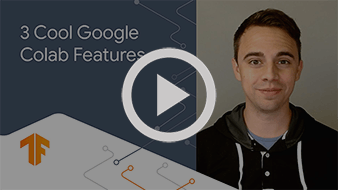
  </a>
</center>

<div class="markdown-google-sans">
  <h2>Colab이란?</h2>
</div>

Colaboratory&#40;줄여서 'Colab'이라고 함&#41;을 통해 브라우저 내에서 Python 스크립트를 작성하고 실행할 수 있습니다.
- 구성이 필요하지 않음
- 무료로 GPU 사용
- 간편한 공유

<strong>학생</strong>이든, <strong>데이터 과학자</strong>든, <strong>AI 연구원</strong>이든 Colab으로 업무를 더욱 간편하게 처리할 수 있습니다. <a href="https://www.youtube.com/watch?v=inN8seMm7UI">Colab 소개 영상</a>에서 자세한 내용을 확인하거나 아래에서 시작해 보세요.

<div class="markdown-google-sans">

## <strong>시작하기</strong>
</div>

지금 읽고 계신 문서는 정적 웹페이지가 아니라 코드를 작성하고 실행할 수 있는 대화형 환경인 <strong>Colab 메모장</strong>입니다.

예를 들어 다음은 값을 계산하여 변수로 저장하고 결과를 출력하는 간단한 Python 스크립트가 포함된 <strong>코드 셀</strong>입니다.

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

위 셀의 코드를 실행하려면 셀을 클릭하여 선택한 후 코드 왼쪽의 실행 버튼을 누르거나 단축키 'Command/Ctrl+Enter'를 사용하세요. 셀을 클릭하면 코드 수정을 바로 시작할 수 있습니다.

특정 셀에서 정의한 변수를 나중에 다른 셀에서 사용할 수 있습니다.

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab 메모장을 사용하면 <strong>실행 코드</strong>와 <strong>서식 있는 텍스트</strong>를 <strong>이미지</strong>, <strong>HTML</strong>, <strong>LaTeX</strong> 등과 함께 하나의 문서로 통합할 수 있습니다. Colab 메모장을 만들면 Google Drive 계정에 저장됩니다. Colab 메모장을 간편하게 공유하여 동료나 친구들이 댓글을 달거나 수정하도록 할 수 있습니다. 자세히 알아보려면 <a href="/notebooks/basic_features_overview.ipynb">Colab 개요</a>를 참조하세요. 새 Colab 메모장을 만들려면 위의 파일 메뉴를 사용하거나 다음 링크로 이동하세요. <a href="http://colab.research.google.com#create=true">새 Colab 메모장 만들기</a>

Colab 메모장은 Colab에서 호스팅하는 Jupyter 메모장입니다. Jupyter 프로젝트에 관해 자세히 알아보려면 <a href="https://www.jupyter.org">jupyter.org</a>를 참조하세요.

<div class="markdown-google-sans">

## 데이터 과학
</div>

Colab을 통해 인기 있는 Python 라이브러리를 최대한 활용하여 데이터를 분석하고 시각화할 수 있습니다. 아래 코드 셀에서는 <strong>Numpy</strong>를 사용하여 임의의 데이터를 생성하고 <strong>매트플롯립</strong>으로 이를 시각화합니다. 셀을 클릭하면 코드 수정을 바로 시작할 수 있습니다.

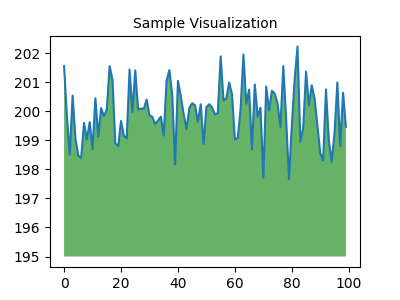

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Google Drive 계정에서 스프레드시트를 비롯한 데이터를 Colab 메모장으로 가져오거나 GitHub 등의 여러 다른 소스에서 데이터를 가져올 수 있습니다. Colab을 데이터 과학에 활용하는 방법과 데이터 가져오기에 관해 자세히 알아보려면 <a href="#working-with-data">데이터 사용하기</a> 아래 링크를 참조하세요.

<div class="markdown-google-sans">

## 머신러닝
</div>

Colab을 사용하면 <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb">코드 몇 줄</a>만으로 이미지 데이터세트를 가져오고, 이 데이터세트로 이미지 분류기를 학습시키며, 모델을 평가할 수 있습니다. Colab 메모장은 Google 클라우드 서버에서 코드를 실행하므로 사용 중인 컴퓨터의 성능과 관계없이 <a href="#using-accelerated-hardware">GPU 및 TPU</a>를 포함한 Google 하드웨어의 성능을 활용할 수 있습니다. 브라우저만 있으면 사용 가능합니다.

Colab은 다음과 같은 분야의 머신러닝 커뮤니티에서 널리 쓰이고 있습니다.
- TensorFlow 시작하기
- 신경망 개발 및 학습시키기
- TPU로 실험하기
- AI 연구 보급하기
- 튜토리얼 만들기

머신러닝 적용 사례를 보여 주는 Colab 메모장 샘플을 확인하려면 아래 <a href="#machine-learning-examples">머신러닝 예시</a>를 참조하세요.

<div class="markdown-google-sans">

## 추가 리소스

### Colab에서 메모장 사용하기

</div>

- [Colaboratory 개요](/notebooks/basic_features_overview.ipynb)
- [Markdown 가이드](/notebooks/markdown_guide.ipynb)
- [라이브러리 가져오기 및 종속 항목 설치하기](/notebooks/snippets/importing_libraries.ipynb)
- [GitHub에서 노트 저장 및 로드하기](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [대화형 양식](/notebooks/forms.ipynb)
- [대화형 위젯](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### 데이터로 작업하기
</div>

- [데이터 로드: 드라이브, 스프레드시트, Google Cloud Storage](/notebooks/io.ipynb)
- [차트: 데이터 시각화하기](/notebooks/charts.ipynb)
- [BigQuery 시작하기](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### 머신러닝 단기집중과정

<div>

다음은 Google 온라인 머신러닝 과정에서 가져온 일부 메모장입니다. <a href="https://developers.google.com/machine-learning/crash-course/">전체 과정 웹사이트</a>에서 자세한 내용을 확인하세요.
- [Pandas DataFrame 소개](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [합성 데이터를 사용하는 tf.keras 선형 회귀](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### 가속 하드웨어 사용하기
</div>

- [GPU를 사용한 TensorFlow](/notebooks/gpu.ipynb)
- [TPU를 사용한 TensorFlow](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### 추천 예시

</div>

- <a href="https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb">NeMo Voice Swap</a>: Nvidia의 NeMo 대화형 AI 툴킷을 사용하여 오디오 파일의 음성을 컴퓨터에서 생성된 음성으로 변환하세요.

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">이미지 분류기 재훈련</a>: 사전에 훈련된 이미지 분류기를 기반으로 꽃을 분류하기 위한 Keras 모델을 구축합니다.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">텍스트 분류</a>: IMDB 영화 리뷰를 <em>긍정적인 리뷰</em> 또는 <em>부정적인 리뷰</em>로 분류합니다.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">스타일 트랜스퍼</a>: 딥 러닝을 사용하여 이미지 간에 스타일을 전이시킵니다.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Multilingual Universal Sentence Encoder Q&amp;A</a>: 머신러닝 모델을 사용하여 SQuAD 데이터 세트의 질문에 답변합니다.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">동영상 보간 유형</a>: 동영상에서 첫 프레임과 마지막 프레임 사이에 발생한 내용을 예측합니다.
